# Example 3: Root Water Uptake

This notebook represents steps to replicate example 3 from: *0David Rassam, Jirka Šimůnek, Dirk Mallants,and Martinus Th. van Genuchten, The HYDRUS-1D Software Package for Simulating the One-Dimensional Movement of Water, Heat, and Multiple Solutes in Variably-Saturated Media* \
Tutorial \
Version 1.00, July 2018

This example provides insctructions to create a Pydrus model that simulating water flow and root water uptake in a 3-m deep uniform soil profile. The soil profile is initially at hydrpstatic equilibrium, i.e., the pressure head changes uniformly from -300 cm at the top of the soil profile to 0 cm at the bottom. Roots are uniformly distributed from the surface down to a depth of 200 cm, which is still 100 cm above the groundwater table. \
The upper boundary and lower boundary are represented with: 

* Upper BC: Atmospheric Boundary Condition with Surface Runoff.
* Bottom BC: Constant Head Boundary (0-cm constant pressure head representing the groundwater table.). 

### 1. Import the Pydrus package

In [1]:
import os
import pandas as pd
import pydrus as ps
import numpy as np
%matplotlib inline

### 2. Create the basic model & add time information

In [2]:
# Folder for Hydrus files to be stored
ws = "example_3"
# Path to folder containing hydrus.exe 
exe = os.path.join(os.getcwd(),"../../source/hydrus.exe")  
# Description
desc = "Root water uptake in a soil profile"
# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model", description=desc, 
              mass_units="mmol", time_unit="days", length_unit="cm")
ml.basic_info["lFlux"] = True
ml.basic_info["lShort"] = False

time = [1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 30]
ml.add_time_info(tmax=30, print_array=time, dt=0.001)

[1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 30]

### 3. Add processes and materials

In [3]:
ml.add_waterflow(model=3, top_bc=3, bot_bc=0)

m = ml.get_empty_material_df(n=1)
m.loc[[1, 1]] = [[0.068, 0.38, 0.008, 1.09, 4.8, 0.5]]
ml.add_material(m)

water                             
     thr   ths   Alfa     n   Ks    l
1  0.068  0.38  0.008  1.09  4.8  0.5

### 4. Add profile information(density to be implemented in ps.create_profile)

In [4]:
nodes = 120  # Disctretize soil column into n elements
depth = -300  # Depth of the soil column
ihead = -100  # Determine initial Pressure Head
# Create Profile
profile = ps.create_profile(bot=depth, dx=abs(depth / (nodes-1)), h=ihead)
# Discretize profile based on node density
tld=0.1  # Lower denstiy at top node
bud=0.3  # Upper density bottom node
def det_h(nodes,depth, tld=1, lud=1):
    midnode = int((nodes*(lud+1)/2+((1+tld)/2))/((1+lud)/2+(1+tld)/2))
    
    def get_dx(tld, lud, nnodes, depth):
        startdx=depth*2/(nnodes-1)/((1+lud/tld))
        enddx = depth/(nnodes-1)*lud/((tld+lud)/2)
        return np.linspace(startdx,enddx,nnodes-1)
    
    dx1 = get_dx(tld, 1, midnode, depth/2)
    dx2 = get_dx(1, lud, nodes-midnode+1, depth/2)
            
    values1=[0]
    value0=0
    for x in dx1:
        y = value0+x
        value0=y
        values1.append(y)
    
    values2=[]
    value0=depth/2
    for x in dx2:
        y = value0+x
        value0=y
        values2.append(y)

    profile = np.concatenate((values1, values2), axis=None)
    return profile
profile["x"] = det_h(nodes,depth, tld, bud)
profile["h"] = np.round(abs(profile["x"])+depth,5)
profile.loc[2:78,"Beta"] = 1
ml.add_profile(profile)

### 5. Add observation nodes

In [5]:
# Add observation nodes at depth
ml.add_obs_nodes([0, -300])

### 6. Add atmosphere boundary conditions

In [6]:
bc = {"tAtm": (3, 30), "Prec": (2, 0), "rSoil": (0.1, 0.1), "rRoot": (0.5, 1.5)}
atm = pd.DataFrame(bc, index=(3, 30))
ml.add_atmospheric_bc(atm, hcrits=0, hcrita=50000)

### 7. Add root water uptake

In [7]:
ml.add_root_uptake(model=0, crootmax=1, poptm=[-25], omegac=1)

### 8. Write hydrus input files and run hydrus

In [8]:
ml.write_input()
ml.simulate()

CompletedProcess(args=['C:\\Matevz_arbeit\\pydrus\\examples\\hydrus_orig\\../../source/hydrus.exe', 'example_3', '-1'], returncode=0)

### 9. Plot results

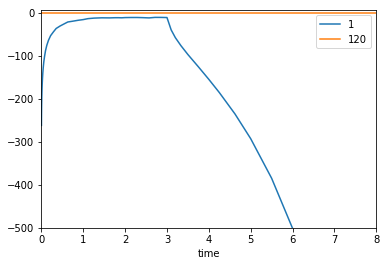

In [9]:
import matplotlib.pyplot as plt
dfs = ml.read_obs_node()
figx, ax=plt.subplots()
for key, df in dfs.items():
    dft = df[:][0:8]
    dft.plot(y="h", use_index=True,ax=ax, label=key)
    ax.set_ylim(-500,5)

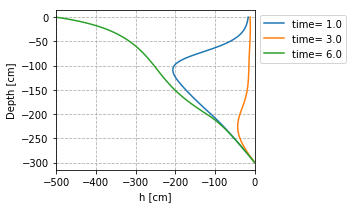

In [10]:
ml.plots.profile_information(times=[1, 3, 6])

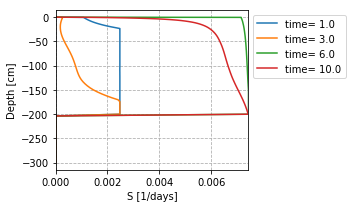

In [11]:
ml.plots.profile_information("Root Uptake", times=[1, 3, 6, 10])

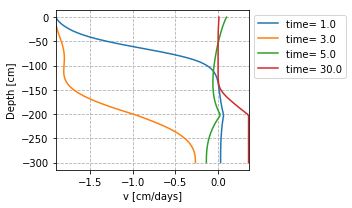

In [12]:
ml.plots.profile_information("Water Flux", times=[1, 3, 5, 30])

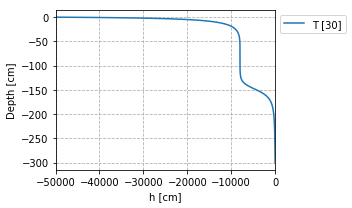

In [13]:
ml.plots.profile_information("Pressure Head", times=[30])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BE36D4F28>,
      dtype=object)

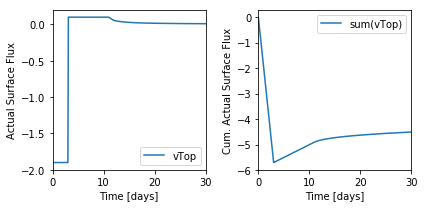

In [14]:
ml.plots.water_flow(data="Actual Surface Flux")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BE47BE630>,
      dtype=object)

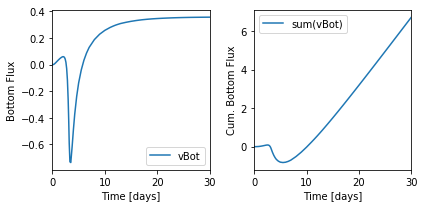

In [15]:
ml.plots.water_flow(data="Bottom Flux")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BE4866978>,
      dtype=object)

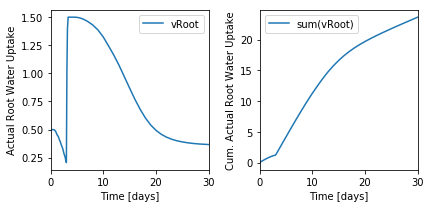

In [16]:
ml.plots.water_flow("Actual Root Water Uptake")